# Model Validation Recipe

## Import Required Libraries

We start by importing the essential libraries for data manipulation and model selection. Pandas will handle our data operations, NumPy provides numerical computing capabilities, and KFold from scikit-learn enables cross-validation functionality.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

## StackerModel Class

A flexible ensemble learning implementation that combines multiple base models using stacking methodology with optional blending for robust predictions.

### Key Features
- **Model Validation**: Automatically detects and handles both `predict` and `predict_proba` methods
- **Flexible Stacking**: Supports simple stacking or advanced blending with cross-validation
- **Metafeature Generation**: Creates higher-level features from base model predictions
- **Universal Predictor**: Unified prediction interface regardless of underlying model types

### Parameters
- `blend` (bool): Enable cross-validation blending for robust metafeatures (default: False)
- `splits` (int): Number of CV folds for blending (default: 5)
- `model_feature_indices` (list): Specify different feature subsets for each model (optional)

### Usage
```python
# Initialize ensemble
stacker = StackerModel()

# Train with blending
stacker.fit(X_train, y_train, models=[rf, lr, dt], stacker=ridge_classifier, blend=True)

# Make predictions
predictions = stacker.predict(X_test)

In [2]:
class StackerModel:
    def __init__(self):
        self.X = None
        self.y = None
        self.blend = None
        self.splits = None
        self.model_feature_indices = None
        self.model_methods = []
        self.metafeatures_df = None
        self.X_with_metafeatures = None
        self.raw_models = None
        self.fit_models = dict()
        self.fit_blended_models = dict()
        self.raw_stacker = None
        self.stacker = None

    def validate_models(self, models):
        for model in models:
            # model name
            model_name = model.__str__().split('(')[0]

            # assert that each model has a predict_proba or predict method
            assert any(['predict' in dir(model), 'predict_proba' in dir(model)]), \
                f'"{model_name} does not have a predict or predict_proba method"'

            # determine which method to use from each of the models in the list and keep stored
            if 'predict_proba' not in dir(model) and 'predict' in dir(model):
                print(f'Note: There is no predict_proba method in {model_name}, therefore predict method will be used')
                self.model_methods.append('predict')

            if 'predict_proba' in dir(model):
                self.model_methods.append('predict_proba')

    @staticmethod
    def model_predictor(model, X, method):
        predictions = None
        if method == 'predict_proba':
            predictions = model.predict_proba(X)[:, 1]
        if method == 'predict':
            predictions = model.predict(X)
        return predictions

    def fit(self, X, y, models, stacker, blend=False, splits=5, model_feature_indices=None):
        # re-initialise so that you can
        self.__init__()

        # some saved variables during fit
        self.raw_models = models
        self.raw_stacker = stacker
        self.blend = blend
        self.splits = splits
        self.model_feature_indices = model_feature_indices

        self.validate_models(models)

        # convert X into a dataframe if not already
        if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
            X = pd.DataFrame(X).reset_index(drop=True)
        # convert y into a dataframe if not already
        if str(type(y)) != """<class 'pandas.core.frame.DataFrame'>""":
            y = pd.DataFrame(y).reset_index(drop=True)

        if self.model_feature_indices is None:
            self.model_feature_indices = [[i for i in range(X.shape[1])] for _ in models]

        self.model_names_list = [model.__str__().split('(')[0] for model in self.raw_models]
        self.metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)

        for model, features, method in zip(self.raw_models, self.model_feature_indices, self.model_methods):
            # model name
            model_name = model.__str__().split('(')[0]

            # train model
            X_model_features = X.iloc[:, features]

            metafeatures = None
            # blending if required
            if self.blend is False:
                model.fit(X_model_features, np.ravel(y))
                metafeatures = self.model_predictor(model, X_model_features, method)
                self.fit_models[model_name] = model

            if self.blend is True:
                self.fit_blended_models[model_name] = []
                kf = KFold(n_splits=self.splits)
                metafeatures = pd.Series(np.zeros(X.shape[0]))

                for idx, (train_idx, meta_idx) in enumerate(kf.split(X_model_features)):
                    model.fit(X_model_features.iloc[train_idx, :], np.ravel(y.iloc[train_idx, :]))
                    meta = self.model_predictor(model, X_model_features.iloc[meta_idx, :], method)
                    metafeatures.iloc[meta_idx] = meta
                    self.fit_blended_models[model_name].append(model)

            self.metafeatures_df[model_name] = metafeatures

        self.X_with_metafeatures = pd.concat([X.reset_index(drop=True), self.metafeatures_df.reset_index(drop=True)], axis=1)
        self.stacker = stacker.fit(self.X_with_metafeatures, np.ravel(y))

    def predict(self, X):
        if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
            X = pd.DataFrame(X).reset_index(drop=True)

        metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)

        if self.blend is False:
            for (model_name, model), features, method in zip(self.fit_models.items(), self.model_feature_indices, self.model_methods):
                X_model_features = X.iloc[:, features]
                metafeatures = self.model_predictor(model, X_model_features, method)
                metafeatures_df[model_name] = metafeatures

        if self.blend is True:
            for (model_name, model_list), features, method in zip(self.fit_blended_models.items(), self.model_feature_indices, self.model_methods):
                X_model_features = X.iloc[:, features]
                model_df = pd.DataFrame()

                for model_idx, model in enumerate(model_list):
                    meta = self.model_predictor(model, X_model_features, method)
                    model_df[model_idx] = meta

                metafeatures = np.mean(model_df, axis=1)
                metafeatures_df[model_name] = metafeatures

        X_with_metafeatures = pd.concat([X.reset_index(drop=True), metafeatures_df.reset_index(drop=True)], axis=1)
        predictions = self.stacker.predict(X_with_metafeatures)
        return predictions

## Initialize the Model Validation Class

The `__init__` method sets up the initial state of our model validation class. All attributes are initialized to None or empty containers, creating a clean slate for storing our data, models, and validation results throughout the modeling process.

In [3]:
def __init__(self):
    self.X = None
    self.y = None
    self.blend = None
    self.splits = None
    self.model_feature_indices = None
    self.model_methods = []
    self.metafeatures_df = None
    self.X_with_metafeatures = None
    self.raw_models = None
    self.fit_models = dict()
    self.fit_blended_models = dict()
    self.raw_stacker = None
    self.stacker = None

## Validate Model Prediction Methods

This method ensures that each model in our ensemble has the appropriate prediction capabilities. It checks whether each model has either a `predict_proba` or `predict` method, then stores the appropriate method name for later use during model fitting and prediction phases.

In [4]:
def validate_models(self, models):
    for model in models:
        # model name
        model_name = model.__str__().split('(')[0]

        # assert that each model has a predict_proba or predict method
        assert any(['predict' in dir(model), 'predict_proba' in dir(model)]), \
            f'"{model_name} does not have a predict or predict_proba method"'

        # determine which method to use from each of the models in the list and keep stored
        if 'predict_proba' not in dir(model) and 'predict' in dir(model):
            print(f'Note: There is no predict_proba method in {model_name}, therefore predict method will be used')
            self.model_methods.append('predict')

        if 'predict_proba' in dir(model):
            self.model_methods.append('predict_proba')

## Create Universal Model Predictor

This static method provides a unified interface for making predictions with any model, regardless of whether it uses `predict` or `predict_proba` methods. It automatically selects the appropriate prediction method and handles probability predictions by extracting the positive class probabilities.

In [5]:
@staticmethod
def model_predictor(model, X, method):
    """
    :param model:
    :param X:
    :param method: 'predict' or 'predict_proba' as per generated list through model validation assertion
    :return:
    """

    predictions = None
    if method == 'predict_proba':
        predictions = model.predict_proba(X)[:, 1]
    if method == 'predict':
        predictions = model.predict(X)

    return predictions

## Fit the Ensemble Model

The main fitting method orchestrates the entire ensemble learning process. It handles data preparation, model validation, feature selection, and implements both simple ensemble and blended ensemble approaches with cross-validation for robust metafeature generation.

In [6]:
def fit(self, X, y, models, stacker, blend=False, splits=5, model_feature_indices=None):
    """
    :param X:
    :param y:
    :param models:
    :param stacker:
    :param blend:
    :param splits:
    :param model_feature_indices:
    :return:
    """

    # re-initialise so that you can
    self.__init__()

    # some saved variables during fit
    self.raw_models = models
    self.raw_stacker = stacker
    self.blend = blend
    self.splits = splits
    self.model_feature_indices = model_feature_indices

    self.validate_models(models)

    # convert X into a dataframe if not already
    if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
        X = pd.DataFrame(X).reset_index(drop=True)
    # convert y into a dataframe if not already
    if str(type(y)) != """<class 'pandas.core.frame.DataFrame'>""":
        y = pd.DataFrame(y).reset_index(drop=True)

    if self.model_feature_indices is None:
        self.model_feature_indices = [[i for i in range(X.shape[1])] for _ in models]

    self.model_names_list = [model.__str__().split('(')[0] for model in self.raw_models]
    self.metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)

    for model, features, method in zip(self.raw_models, self.model_feature_indices, self.model_methods):
        # model name
        model_name = model.__str__().split('(')[0]

        # train model
        X_model_features = X.iloc[:, features]

        metafeatures = None
        # blending if required
        if self.blend is False:

            model.fit(X_model_features, np.ravel(y))

            metafeatures = self.model_predictor(model, X_model_features, method)

            # store fit model for future metafeature predictions
            self.fit_models[model_name] = model

        if self.blend is True:
            self.fit_blended_models[model_name] = []
            # folder for blending
            kf = KFold(n_splits=self.splits)

            # metafeatures
            metafeatures = pd.Series(np.zeros(X.shape[0]))

            for idx, (train_idx, meta_idx) in enumerate(kf.split(X_model_features)):
                # fit to train
                model.fit(X_model_features.iloc[train_idx, :], np.ravel(y.iloc[train_idx, :]))

                meta = self.model_predictor(model, X_model_features.iloc[meta_idx, :], method)

                # append metas
                metafeatures.iloc[meta_idx] = meta

                # store fit model for future metafeature predictions
                self.fit_blended_models[model_name].append(model)

        # append metafeatures to the metafeature dataframe
        self.metafeatures_df[model_name] = metafeatures

    # create final df with metafeatures
    self.X_with_metafeatures = pd.concat([X.reset_index(drop=True), self.metafeatures_df.reset_index(drop=True)], axis=1)

    # final stacked X-fit
    self.stacker = stacker.fit(self.X_with_metafeatures, np.ravel(y))

## Generate Predictions from Fitted Ensemble

This method uses the trained ensemble to make predictions on new data. It recreates the metafeatures using the fitted models, then applies the stacker for final predictions. The process differs based on whether blending was used during training.

In [7]:
def predict(self, X):
    """
    prediction function using the models built in the fit method.
    :param X:
    :return:
    """

    # convert X into a dataframe if not already
    if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
        X = pd.DataFrame(X).reset_index()

    metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)

    if self.blend is False:

        for (model_name, model), features, method in zip(self.fit_models.items(), self.model_feature_indices, self.model_methods):

            X_model_features = X.iloc[:, features]

            metafeatures = self.model_predictor(model, X_model_features, method)

            metafeatures_df[model_name] = metafeatures

    if self.blend is True:

        # loop through all the available model types
        for (model_name, model_list), features, method in zip(self.fit_blended_models.items(), self.model_feature_indices, self.model_methods):

            X_model_features = X.iloc[:, features]

            model_df = pd.DataFrame()

            # loop through all the different models that were split during blended
            for model_idx, model in enumerate(model_list):

                # predict meta
                meta = self.model_predictor(model, X_model_features, method)

                model_df[model_idx] = meta

            # average predictions from all different models from the blending process
            metafeatures = np.mean(model_df, axis=1)

            metafeatures_df[model_name] = metafeatures

    X_with_metafeatures = pd.concat([X.reset_index(drop=True), metafeatures_df.reset_index(drop=True)], axis=1)

    # make predictions
    predictions = self.stacker.predict(X_with_metafeatures)

    return predictions

## Complete Ensemble Learning Implementation

This comprehensive example demonstrates how to implement and evaluate a complete ensemble learning pipeline using the StackerModel class. We'll compare individual models against a stacked ensemble with blending to show the performance improvements.

### Import Required Libraries and Setup

First, we import all necessary libraries for machine learning, including our ensemble models, evaluation metrics, and visualization tools. We also set up reproducible random seeds.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

np.random.seed(np.sum([ord(i) for i in 'StackerPy Testing']))

### Load and Prepare the Dataset

We load the dataset and split it into features (X) and target variable (y), then create training and testing sets with a 80/20 split for proper model evaluation.

In [10]:
df = pd.read_csv("/content/VLagun_Total_Years4.csv")

X = df.iloc[:, 0:57].values  # feature metric
Y = df.iloc[:, 57].values

X = df.iloc[:,0:57]
Y = df.iloc[:,57]
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=np.sum([ord(i) for i in 'StackerPy'])
)

# Results df creation for storage
results = pd.DataFrame()

Shape of X_train: (96, 57)
Shape of X_test: (24, 57)


### Train and Evaluate Individual Base Models

We train each base model individually to establish baseline performance metrics. This allows us to compare how much improvement the ensemble provides over individual models.

#### Random Forest Classifier

In [11]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, np.ravel(y_train))
random_forest_predictions = random_forest.predict(X_test)

print('Original Random Forest Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=random_forest_predictions
    )
)

random_forest_accuracy = accuracy_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_recall = recall_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_precision = precision_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_f1 = f1_score(y_true=y_test, y_pred=random_forest_predictions)

print('Accuracy Score: ', random_forest_accuracy)
print('Recall Score: ', random_forest_recall)
print('Precision Score: ', random_forest_precision)
print('F1 Score: ', random_forest_f1)

print('*'*100)

Original Random Forest Classifier Results
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

Accuracy Score:  0.9583333333333334
Recall Score:  0.9333333333333333
Precision Score:  1.0
F1 Score:  0.9655172413793104
****************************************************************************************************


#### Logistic Regression Classifier

In [12]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X_train, np.ravel(y_train))
logistic_predictions = logistic.predict(X_test)

print('Original Logistic Regression Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=logistic_predictions
    )
)

logistic_accuracy = accuracy_score(y_true=y_test, y_pred=logistic_predictions)
logistic_recall = recall_score(y_true=y_test, y_pred=logistic_predictions)
logistic_precision = precision_score(y_true=y_test, y_pred=logistic_predictions)
logistic_f1 = f1_score(y_true=y_test, y_pred=logistic_predictions)

print('Accuracy Score: ', logistic_accuracy)
print('Recall Score: ', logistic_recall)
print('Precision Score: ', logistic_precision)
print('F1 Score: ', logistic_f1)

print('*'*100)

Original Logistic Regression Classifier Results
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.87      0.93        15

    accuracy                           0.92        24
   macro avg       0.91      0.93      0.91        24
weighted avg       0.93      0.92      0.92        24

Accuracy Score:  0.9166666666666666
Recall Score:  0.8666666666666667
Precision Score:  1.0
F1 Score:  0.9285714285714286
****************************************************************************************************


#### Decision Tree Classifier

In [13]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, np.ravel(y_train))
dtree_predictions = dtree.predict(X_test)

print('Original Decision Tree Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=dtree_predictions
    )
)

dtree_accuracy = accuracy_score(y_true=y_test, y_pred=dtree_predictions)
dtree_recall = recall_score(y_true=y_test, y_pred=dtree_predictions)
dtree_precision = precision_score(y_true=y_test, y_pred=dtree_predictions)
dtree_f1 = f1_score(y_true=y_test, y_pred=dtree_predictions)

print('Accuracy Score: ', dtree_accuracy)
print('Recall Score: ', dtree_recall)
print('Precision Score: ', dtree_precision)
print('F1 Score: ', dtree_f1)

print('*'*100)

Original Decision Tree Classifier Results
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.87      0.87      0.87        15

    accuracy                           0.83        24
   macro avg       0.82      0.82      0.82        24
weighted avg       0.83      0.83      0.83        24

Accuracy Score:  0.8333333333333334
Recall Score:  0.8666666666666667
Precision Score:  0.8666666666666667
F1 Score:  0.8666666666666667
****************************************************************************************************


#### Ridge Classifier

In [14]:
ridge = RidgeClassifier()
ridge.fit(X_train, np.ravel(y_train))
ridge_predictions = ridge.predict(X_test)

print('Original Ridge Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=ridge_predictions
    )
)

ridge_accuracy = accuracy_score(y_true=y_test, y_pred=ridge_predictions)
ridge_recall = recall_score(y_true=y_test, y_pred=ridge_predictions)
ridge_precision = precision_score(y_true=y_test, y_pred=ridge_predictions)
ridge_f1 = f1_score(y_true=y_test, y_pred=ridge_predictions)

print('Accuracy Score: ', ridge_accuracy)
print('Recall Score: ', ridge_recall)
print('Precision Score: ', ridge_precision)
print('F1 Score: ', ridge_f1)

print('*'*100)

Original Ridge Classifier Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        15

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Accuracy Score:  1.0
Recall Score:  1.0
Precision Score:  1.0
F1 Score:  1.0
****************************************************************************************************


### Create and Train the Stacked Ensemble with Blending

Now we create our ensemble using the StackerModel with blending enabled. The base models generate metafeatures through cross-validation, and a Ridge classifier serves as the final stacker to combine their predictions.

In [16]:
# Stacker Model classifier results / eval with blending
lr2 = LogisticRegression(solver='lbfgs', max_iter=10000)
dt2 = DecisionTreeClassifier()
rf2 = RandomForestClassifier(n_estimators=25)
rc2 = RidgeClassifier()
models = [lr2, dt2, rf2]

stacker = StackerModel()
stacker.fit(
    X=X_train,
    y=y_train,
    models=models,
    stacker=rc2,
    blend=True,
    splits=5,
    model_feature_indices=None
)

stacker_predictions = stacker.predict(X_test)

print('Stacker Model Results with blending')
print(
    classification_report(
        y_true=y_test,
        y_pred=stacker_predictions
    )
)

stacker_accuracy = accuracy_score(y_true=y_test, y_pred=stacker_predictions)
stacker_recall = recall_score(y_true=y_test, y_pred=stacker_predictions)
stacker_precision = precision_score(y_true=y_test, y_pred=stacker_predictions)
stacker_f1 = f1_score(y_true=y_test, y_pred=stacker_predictions)

print('Accuracy Score: ', stacker_accuracy)
print('Recall Score: ', stacker_recall)
print('Precision Score: ', stacker_precision)
print('F1 Score: ', stacker_f1)

print('*'*100)

Stacker Model Results with blending
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

Accuracy Score:  0.9583333333333334
Recall Score:  0.9333333333333333
Precision Score:  1.0
F1 Score:  0.9655172413793104
****************************************************************************************************


### Compile and Visualize Results

Finally, we organize all model performance metrics into a structured format and create visualizations to compare the effectiveness of individual models versus the ensemble approach.

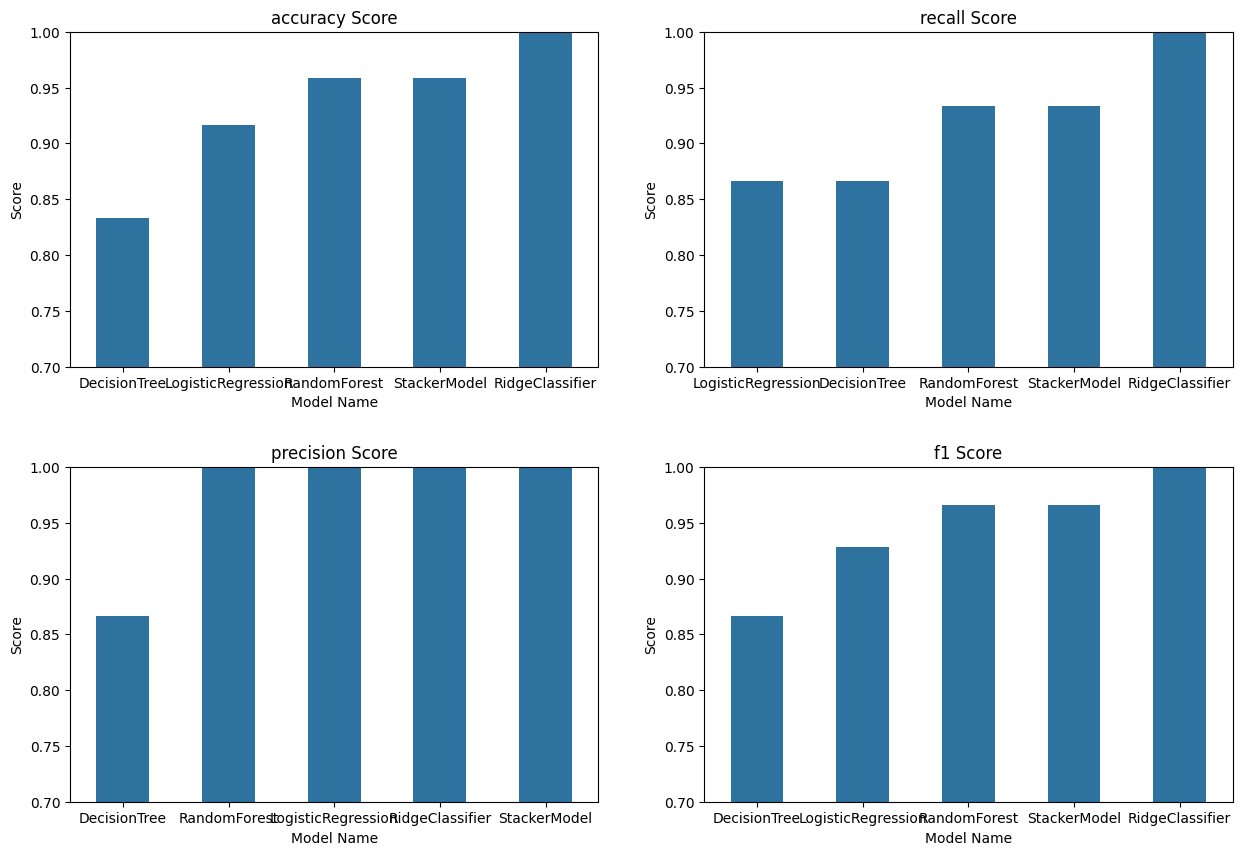

In [17]:
# Compile all results for comparison
results['model'] = ['RandomForest', 'LogisticRegression', 'DecisionTree', 'RidgeClassifier', 'StackerModel']

results['accuracy'] = [random_forest_accuracy, logistic_accuracy, dtree_accuracy, ridge_accuracy, stacker_accuracy]

results['recall'] = [random_forest_recall, logistic_recall, dtree_recall, ridge_recall, stacker_recall]

results['precision'] = [random_forest_precision, logistic_precision, dtree_precision, ridge_precision, stacker_precision]

results['f1'] = [random_forest_f1, logistic_f1, dtree_f1, ridge_f1, stacker_f1]

# Create performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
((ax1, ax2), (ax3, ax4)) = axes

for ax, score in zip([ax1, ax2, ax3, ax4], results.columns[1:]):
    ax.set_title(f'{score} Score')
    ax.set_ylabel('Score')
    results.set_index('model')[score].sort_values().plot(kind='bar', ax=ax, fontsize=10, color='#2E73A0')
    ax.set_xlabel('Model Name')
    ax.set_ylim([0.7, 1])
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)